# Tabular Playground Competition
https://www.kaggle.com/c/tabular-playground-series-jan-2021

In [29]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('ggplot')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(16,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title(f'{feature} Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1, bins=50, fit=stats.norm, color = '#2166ac', hist_kws=dict(alpha=0.5), kde_kws=dict(linewidth=3))
    ax1.legend(labels=['target','normal'])

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)
    ax2.get_lines()[0].set_color('#2166ac')
    ax2.get_lines()[1].set_color('#b2182b')
    ax2.get_lines()[1].set_linewidth(3.0)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(y = df.loc[:,feature], ax = ax3, orient="v", color = '#2166ac', linewidth = 3, whiskerprops=dict(color="black"))

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
# https://www.kaggle.com/hamditarek/tabular-playground-series-xgboost-lightgbm
import lightgbm as lgb

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

In [31]:
plt.style.use('ggplot')

In [34]:
path='/Users/irak/Documents/py_viz/tabular-playground-series-jan-2021/'
# path='/Users/nikli/Documents/git_reps/Data/tabular_playground/'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/irak/Documents/py_viz/tabular-playground-series-jan-2021/test.csv
/Users/irak/Documents/py_viz/tabular-playground-series-jan-2021/train.csv
/Users/irak/Documents/py_viz/tabular-playground-series-jan-2021/sample_submission.csv


Содержание:
#### 1) <a href='#EDA'> Исследовательский анализ данных / предобработка</a>
- <a href='#describe'> Изучечние датасета</a>
- <a href='#Vizualization'> Исследовательский анализ данных / визуализация</a>
- <a href='#EDA conclusion'> Вывод по EDA</a>

#### 2) <a href='#Model training'> Обучение модели</a>
- <a href='#Ordinal Encoding'> Кодирование категориальных признаков</a>
- <a href='#Traintestsplit'> Подготовка обучающей и тестовой выборок</a>
- <a href='#Scaling'> Масштабирование</a>
- <a href='#Results table'> Подготовка таблицы с результатами</a>
- <a href='#Logistic Regression'> Logistic Regression</a>
- <a href='#Random Forest'> Random Forest</a>
- <a href='#XGBoost'> XGBoost</a>
- <a href='#Logistic Regression + XGBoost'> Logistic Regression + XGBoost</a>

#### 3) <a href='#Conclusion'> Вывод</a>

### <a id='EDA'> Исследовательский анализ данных / визуализация</a>
- <a id='describe'> Изучечние датасета</a>


In [35]:
train = pd.read_csv(path+'train.csv', sep=',', index_col='id')
sample_submission=pd.read_csv(path+'sample_submission.csv', sep=',', index_col='id')
test = pd.read_csv(path+'test.csv', sep=',', index_col='id')

print('train data')
display(train.head())

train data


cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
id                                                                         
1   0.670390  0.811300  0.643968  0.291791  0.284117  0.855953  0.890700   
3   0.388053  0.621104  0.686102  0.501149  0.643790  0.449805  0.510824   
4   0.834950  0.227436  0.301584  0.293408  0.606839  0.829175  0.506143   
5   0.820708  0.160155  0.546887  0.726104  0.282444  0.785108  0.752758   
8   0.935278  0.421235  0.303801  0.880214  0.665610  0.830131  0.487113   

       cont8     cont9    cont10    cont11    cont12    cont13    cont14  \
id                                                                         
1   0.285542  0.558245  0.779418  0.921832  0.866772  0.878733  0.305411   
3   0.580748  0.418335  0.432632  0.439872  0.434971  0.369957  0.369484   
4   0.558771  0.587603  0.823312  0.567007  0.677708  0.882938  0.303047   
5   0.823267  0.574466  0.580843  0.769594  0.818143  0.914281  0.279528   
8   0.604157  0.874658  0.863427  0.983575  0.900464  0.935918  0.435772   

      target  
id            
1   7.243043  
3   8.203331  
4   7.776091  
5   6.957716  
8   7.951046

На кагле написано ,что это просто датасет для обучения, у данных признаков нет никаких целей и описания, как и у таргета.
1. Посмотрим на распределение таргета

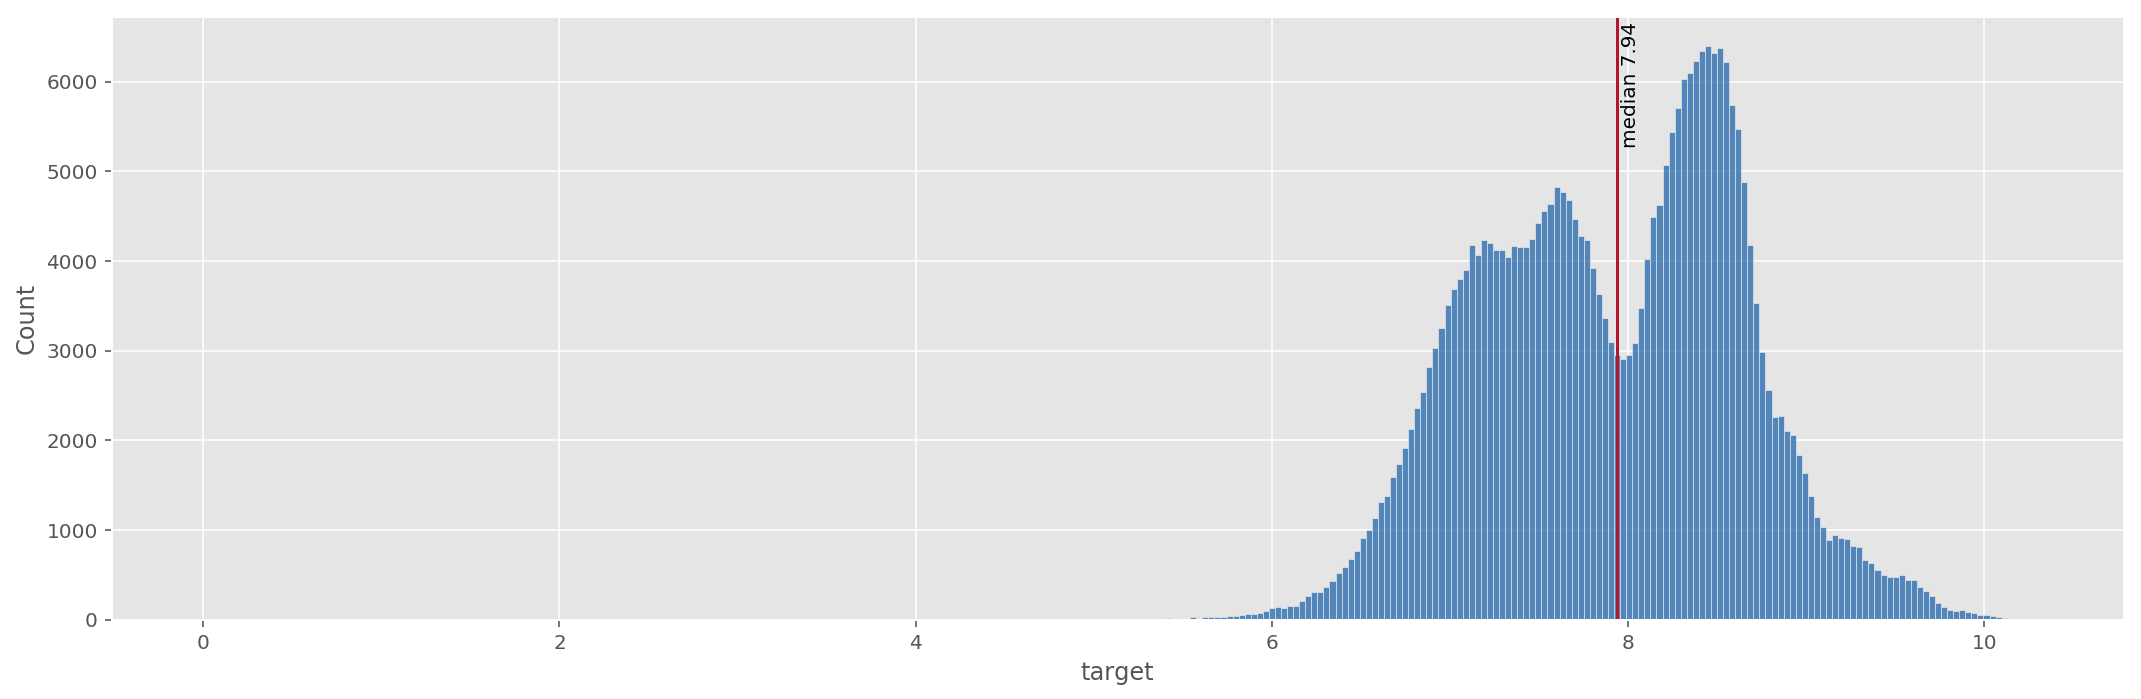

In [36]:
ax = sns.displot(train['target'], aspect=3, color = '#2166ac')
plt.axvline(train['target'].median(), 0, color="#b2182b")
lab = plt.text(train['target'].median() + 0.02 ,6500,'median 7.94', rotation=90)

Подробнее

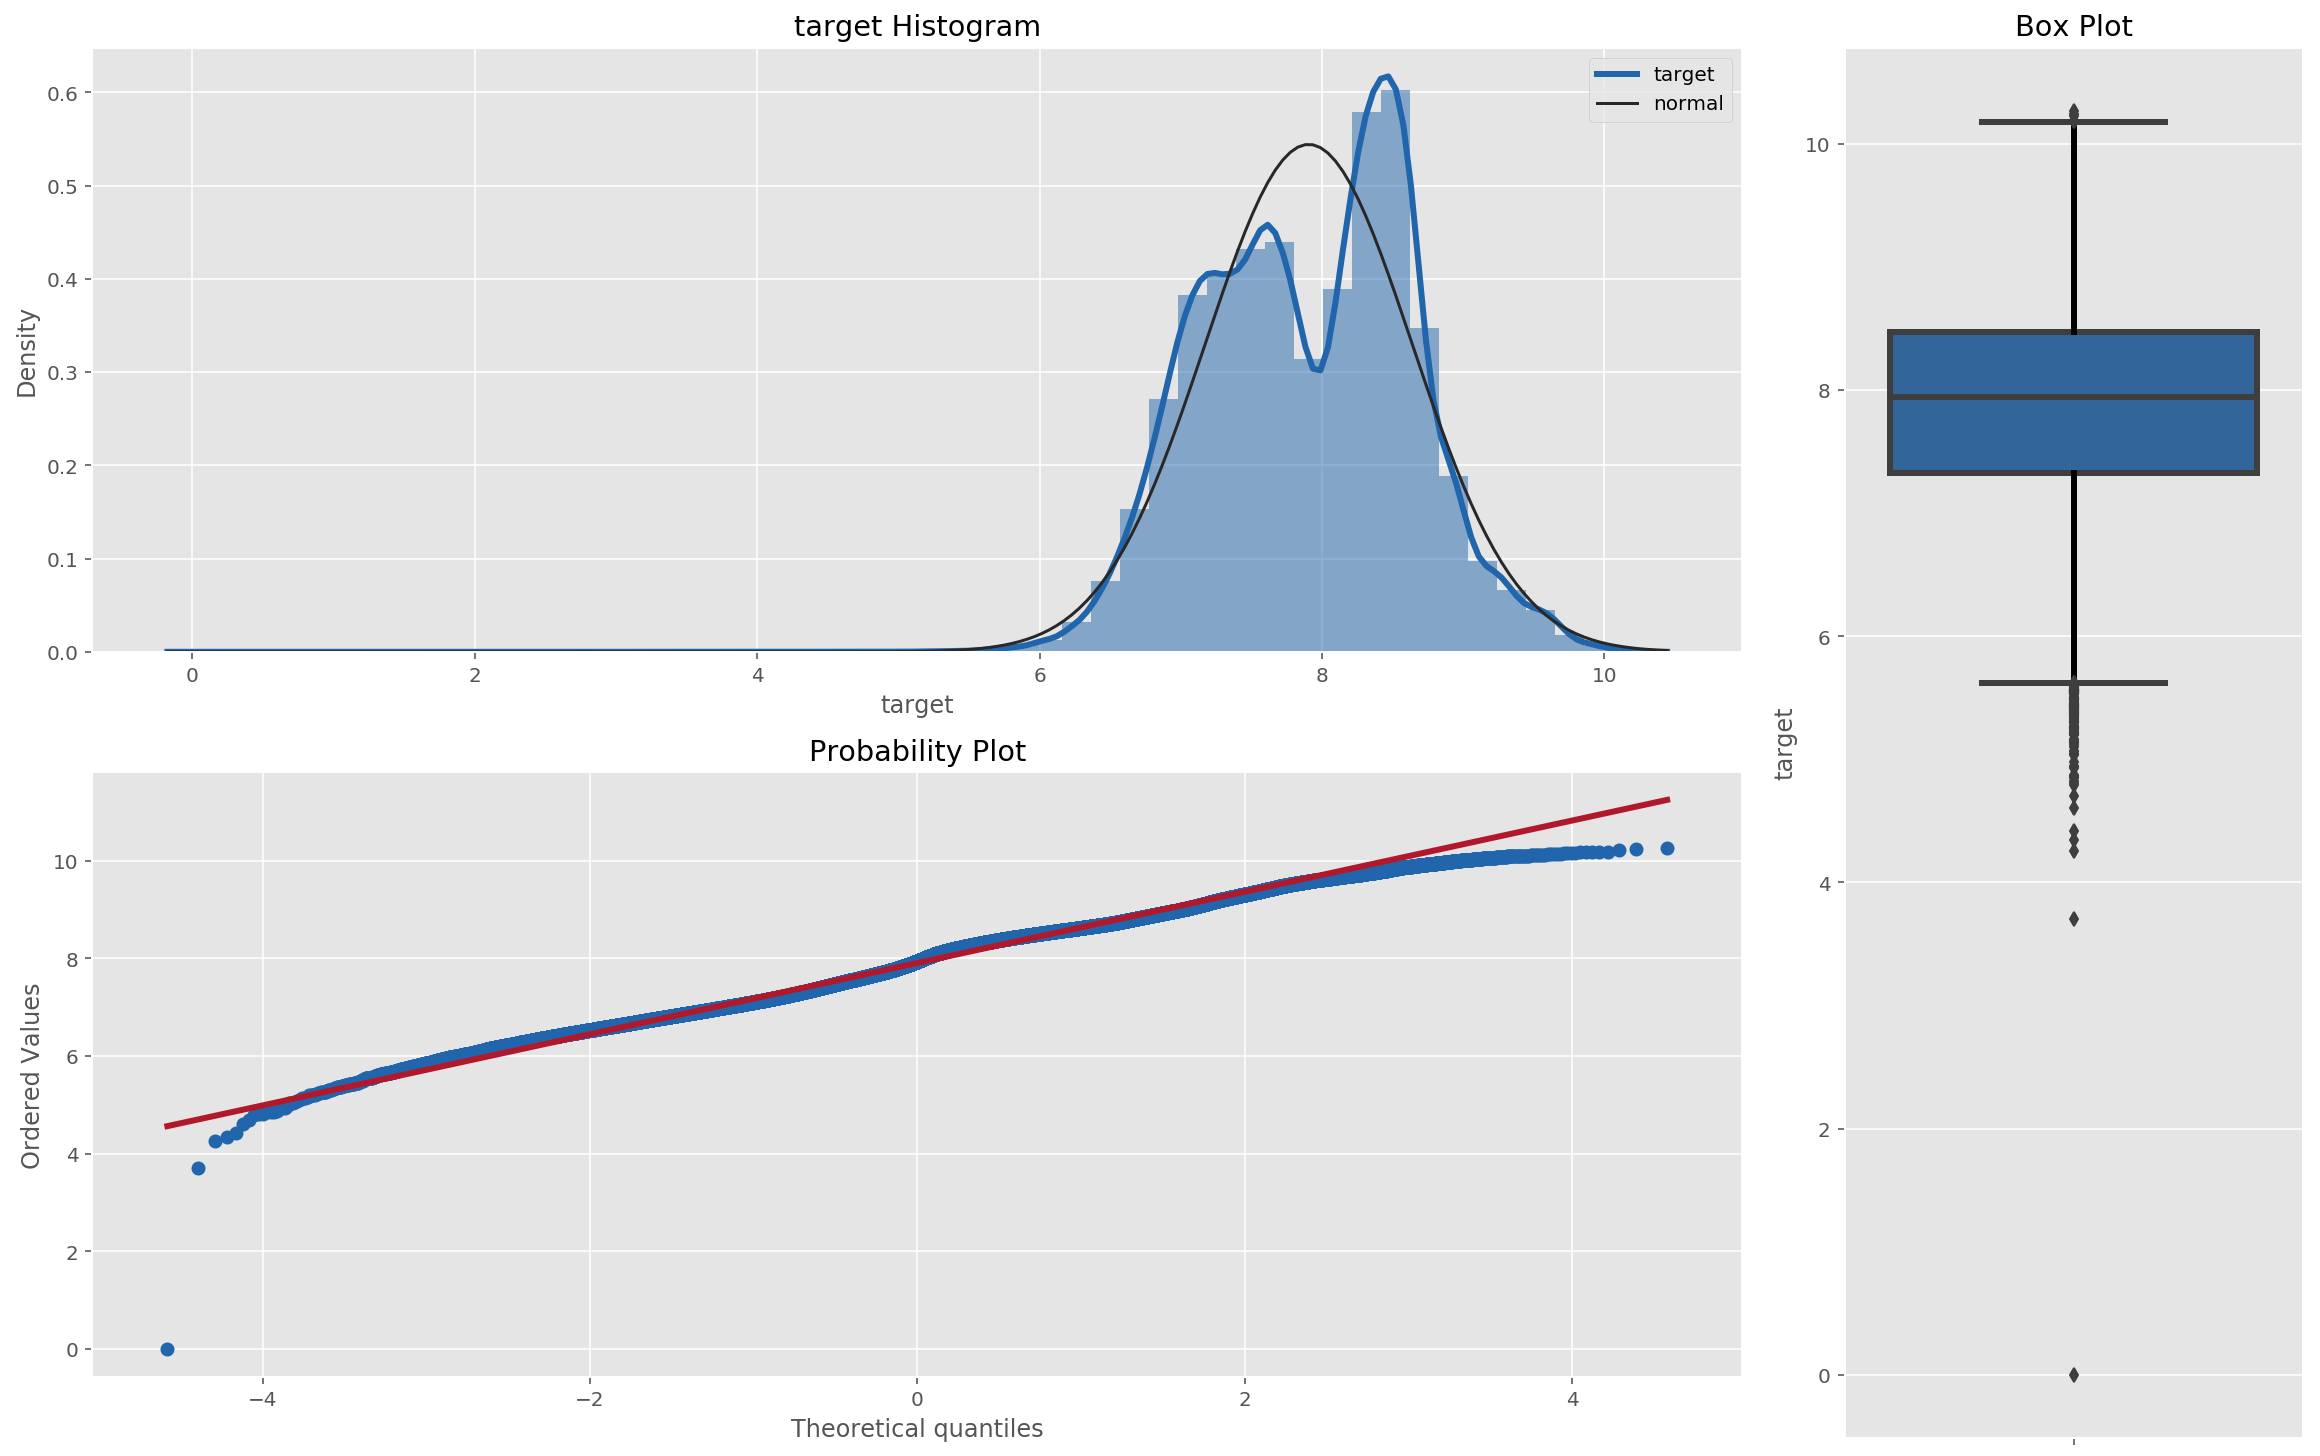

In [37]:
plotting_3_chart(train, 'target') # source https://goldinlocks.github.io/linear_regression_intro/

У нас есть выбросы, как миннимум trarget==0, нужно исключить выбросы

In [38]:
train=train[train['target']>0]
train.shape

(299999, 15)

Посмотрим на пропуски данных

In [39]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


Данные без пропусков, распределение таргета бимодальное. Стоит посмотреть на распределения переменных

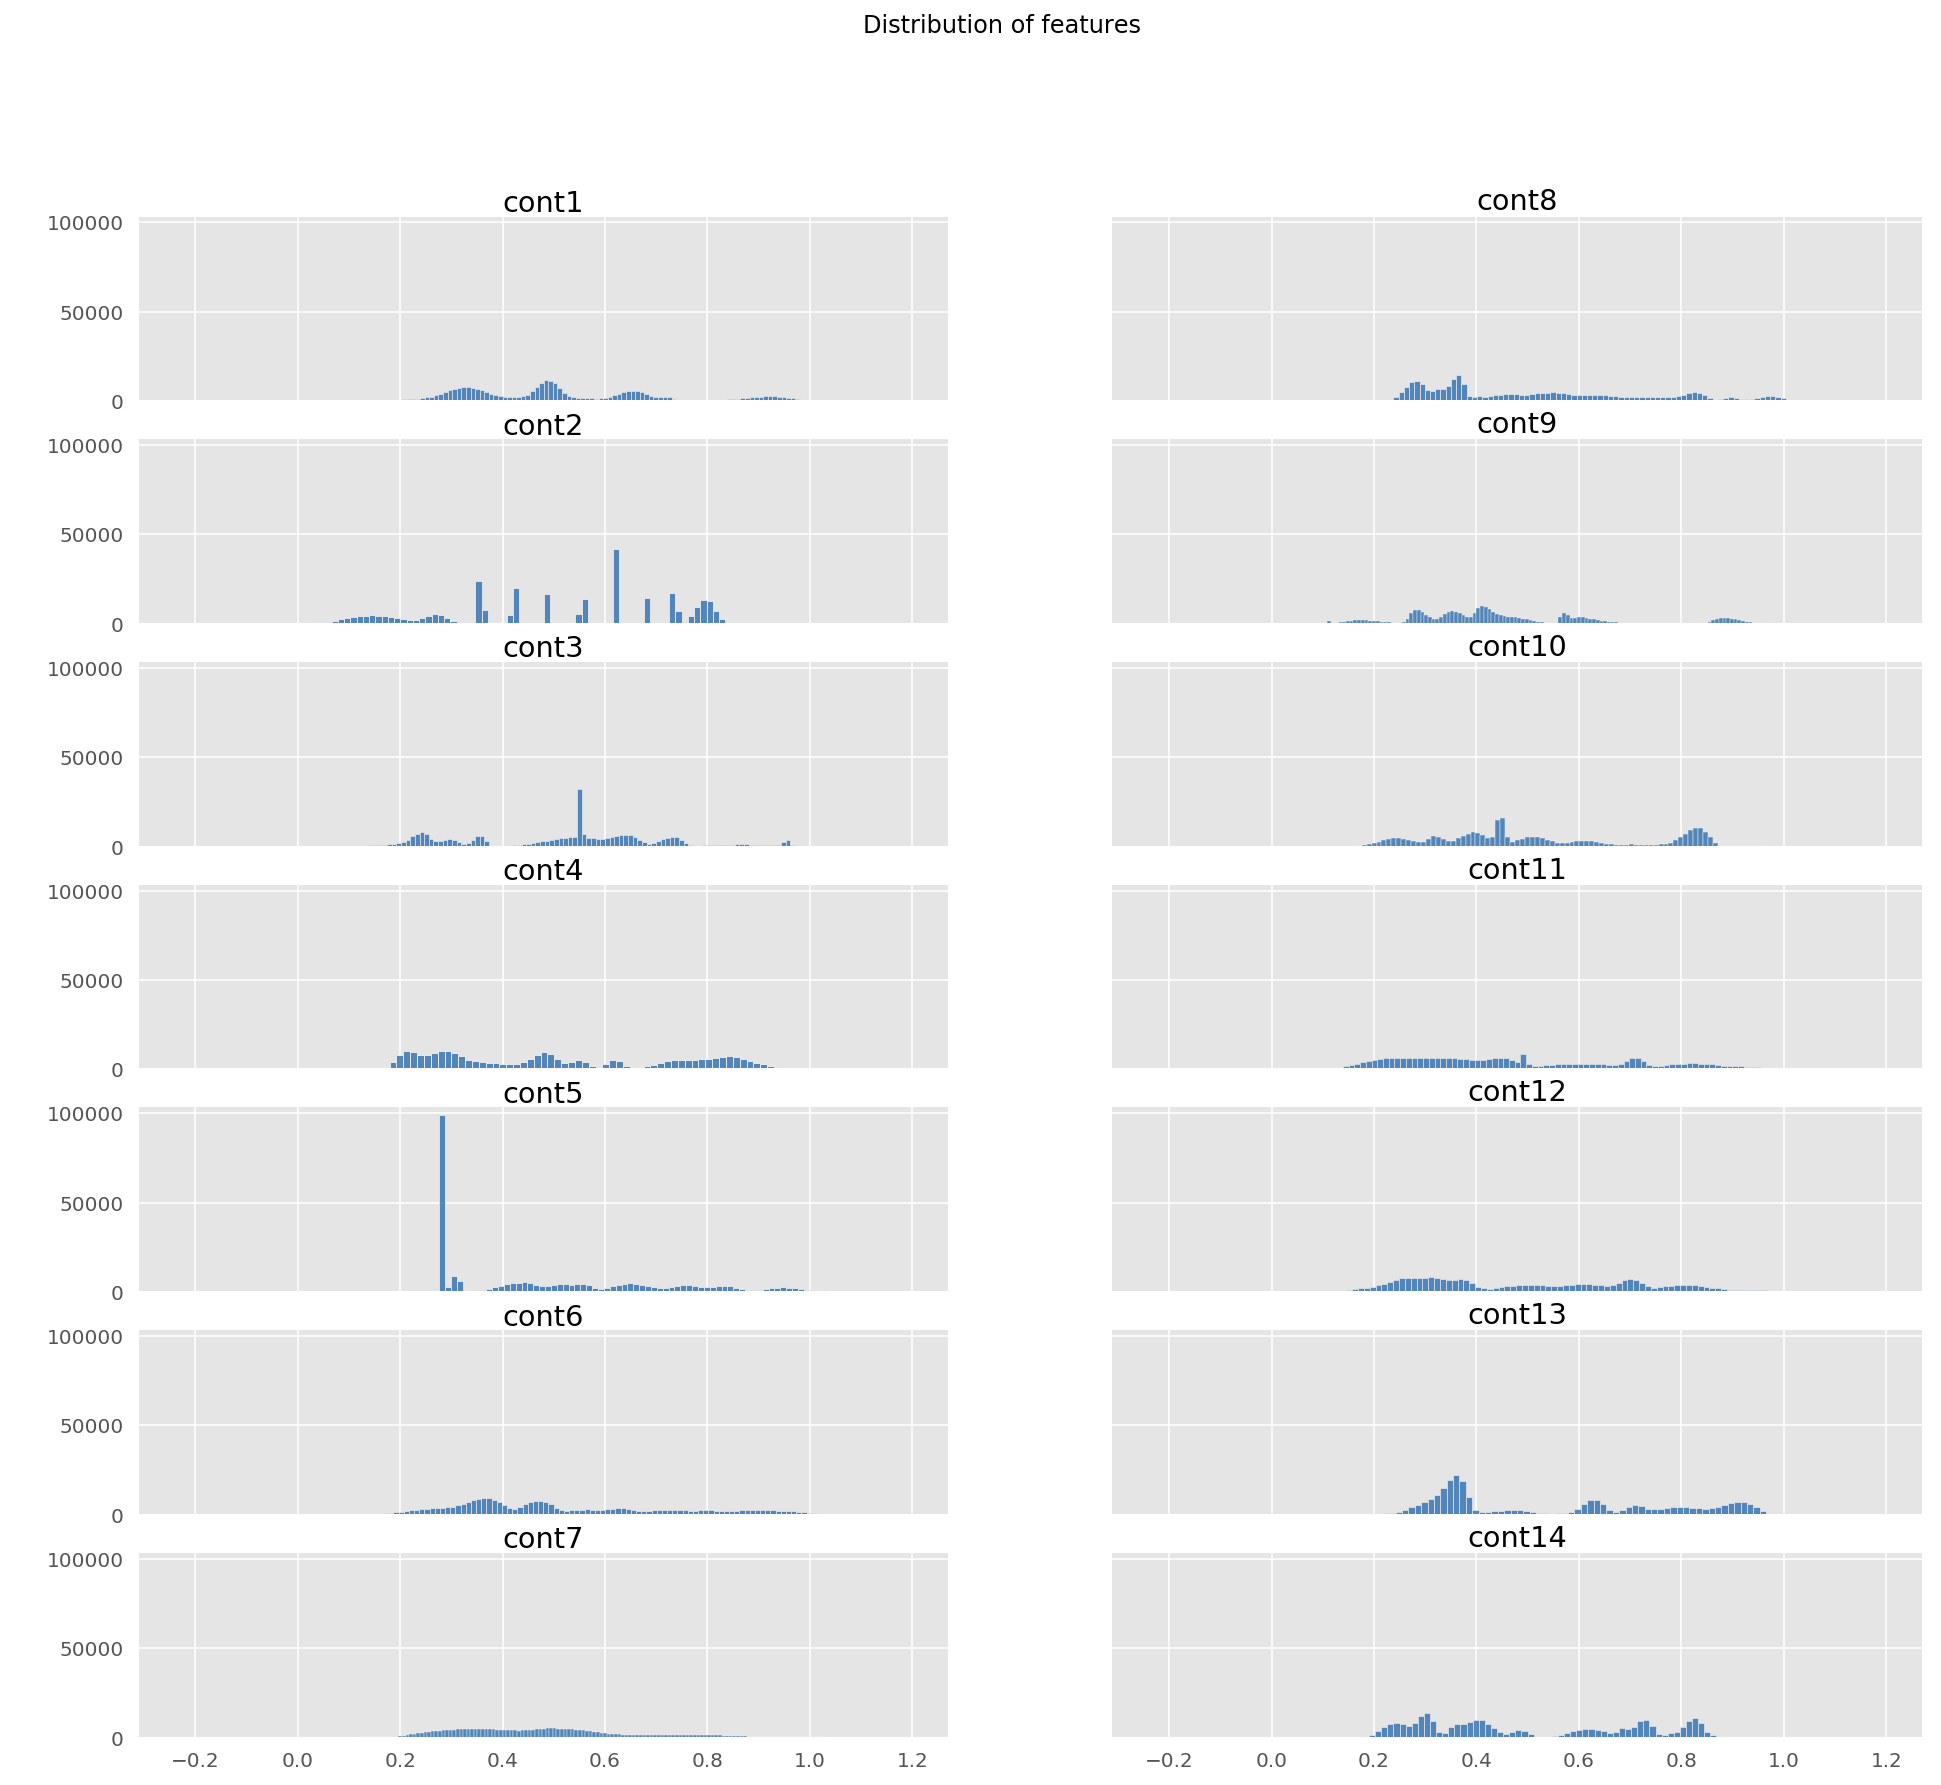

In [40]:
fig, axes = plt.subplots(7, 2, sharex=True, sharey=True, figsize=(16,14))
fig.suptitle('Distribution of features')
plt.subplots_adjust(hspace = 0.2)


n = 0
for c in train.iloc[:,:7].columns:
    sns.histplot(ax=axes[n, 0], data = train[c].values, color = '#2166ac')
    axes[n, 0].set_title(train.columns[n], pad = 2)
    for tic in axes[n, 0].xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in axes[n, 0].yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    n+=1
    
k = 0
for c in train.iloc[:,7:14].columns:
    sns.histplot(ax=axes[k, 1], data = train[c].values, color = '#2166ac')
    axes[k, 1].set_title(train.columns[k + 7], pad = 2.8)
    for tic in axes[k, 1].xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in axes[k, 1].yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    k+=1

for a in axes.flat:
    a.set(ylabel=' ')

Некоторые из распределений сильно отличаются от большинства - cont2, cont3, cont5. Они смещают общую для всех графиков шкалу Y, поэтому их придётся отделить, чтобы увидеть распределения с меньшими пиками.

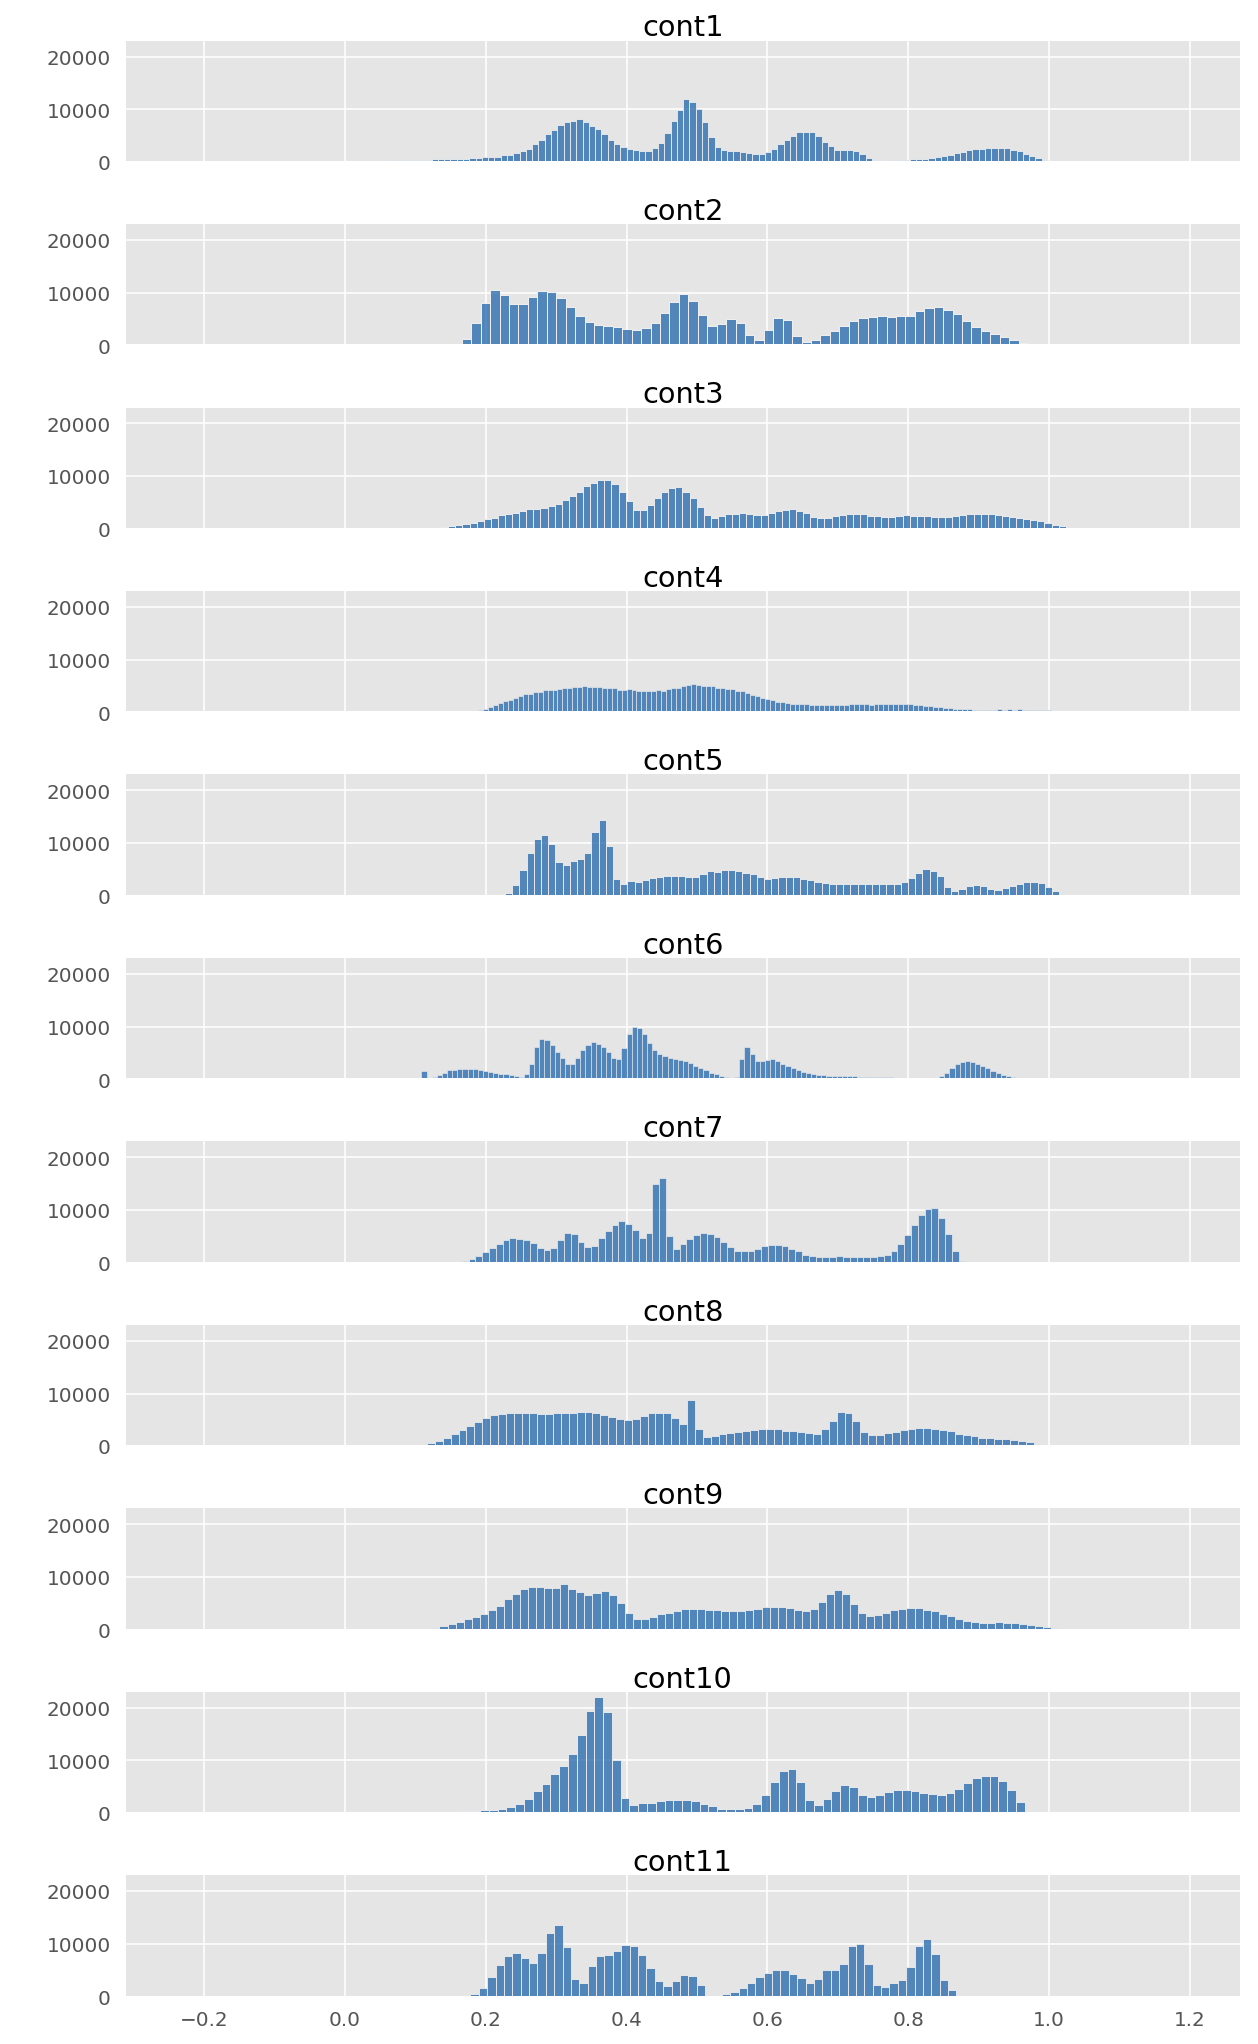

In [41]:
fig, axes = plt.subplots(11, 1, sharex=True, sharey=True, figsize=(10,18))
plt.subplots_adjust(hspace = 0.5)
n = 0
for c in [train.columns[0], train.columns[3]] + train.columns[5:14].tolist():
    sns.histplot(ax=axes[n], data = train[c].values, color = '#2166ac')
    axes[n].set_title(train.columns[n], pad = 2)
    for tic in axes[n].xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in axes[n].yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    n+=1
for a in axes.flat:
    a.set(ylabel=' ')

Посмотрим на оставшиеся распределения отдельно

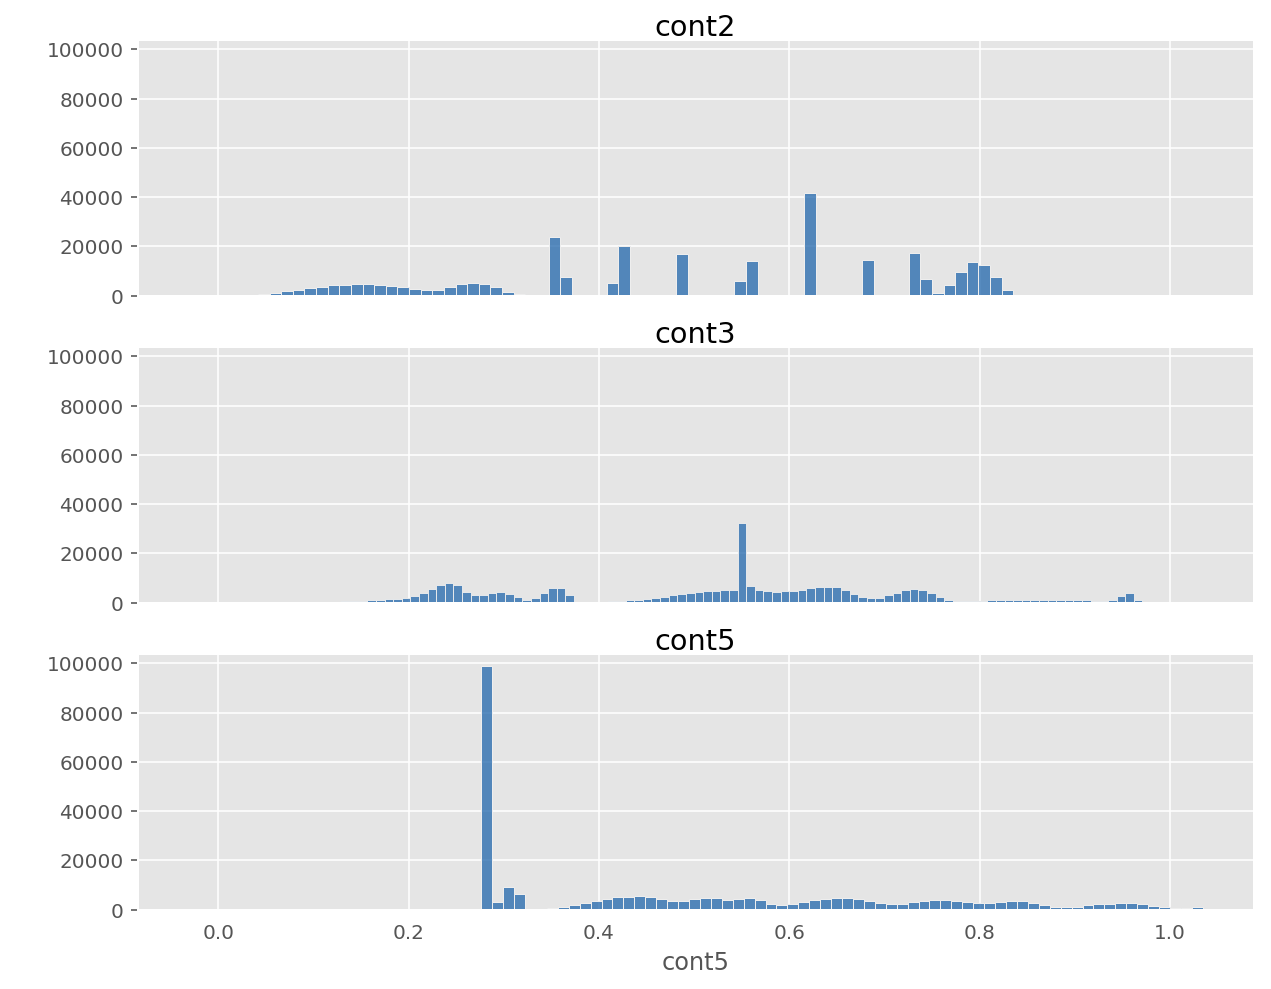

In [42]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10,8))
sns.histplot(ax=axes[0], data = train.iloc[:,1], color = '#2166ac')
for tic in axes[0].xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
lab2 = axes[0].set_title(train.columns[1], pad = 2)
# axes[0].set_facecolor('whitesmoke')
sns.histplot(ax=axes[1], data = train.iloc[:,2], color = '#2166ac')
for tic in axes[1].xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
lab3 = axes[1].set_title(train.columns[2], pad = 2)
# axes[1].set_facecolor('whitesmoke')
sns.histplot(ax=axes[2], data = train.iloc[:,4], color = '#2166ac')
for tic in axes[2].xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
lab5 = axes[2].set_title(train.columns[4], pad = 2)

for a in axes.flat:
    a.set(ylabel=' ')

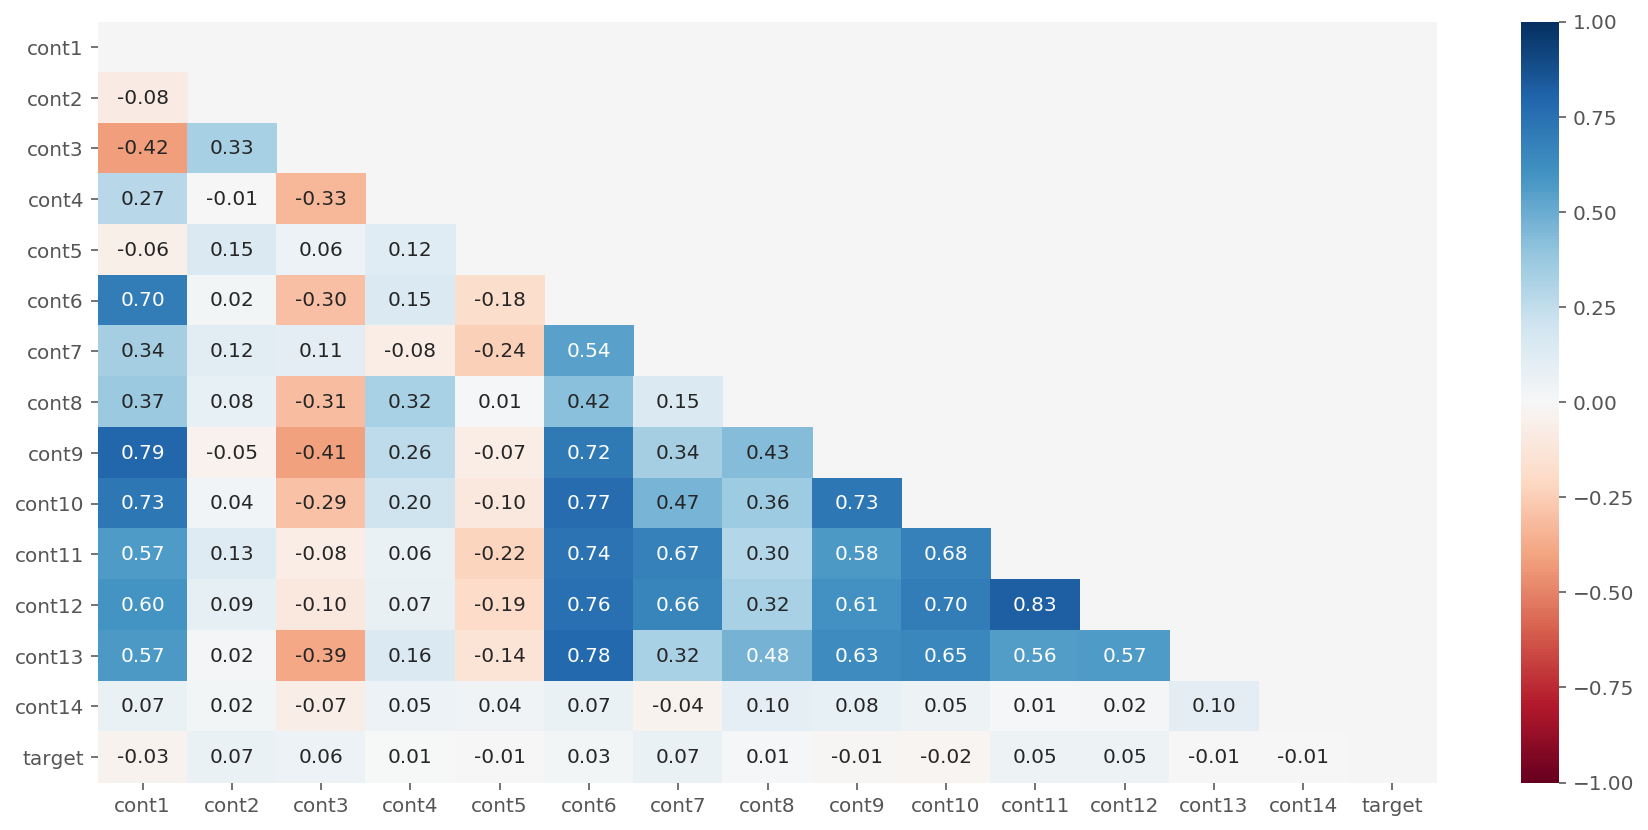

In [43]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(15, 7))
ax = sns.heatmap(corr, cmap="RdBu", mask = mask, vmin=-1, vmax = 1, center = 0, annot=True, fmt='.2f')
ax.set_facecolor("whitesmoke")

cont12 & cont11 имеют самую большую корреляцию.

Посмотрим на выбросы. Target исключен, у него слишком далёкая медиана

In [44]:
sorted_index = train.iloc[:,:14].median().sort_values(ascending=False).index
train_sorted=train[sorted_index]

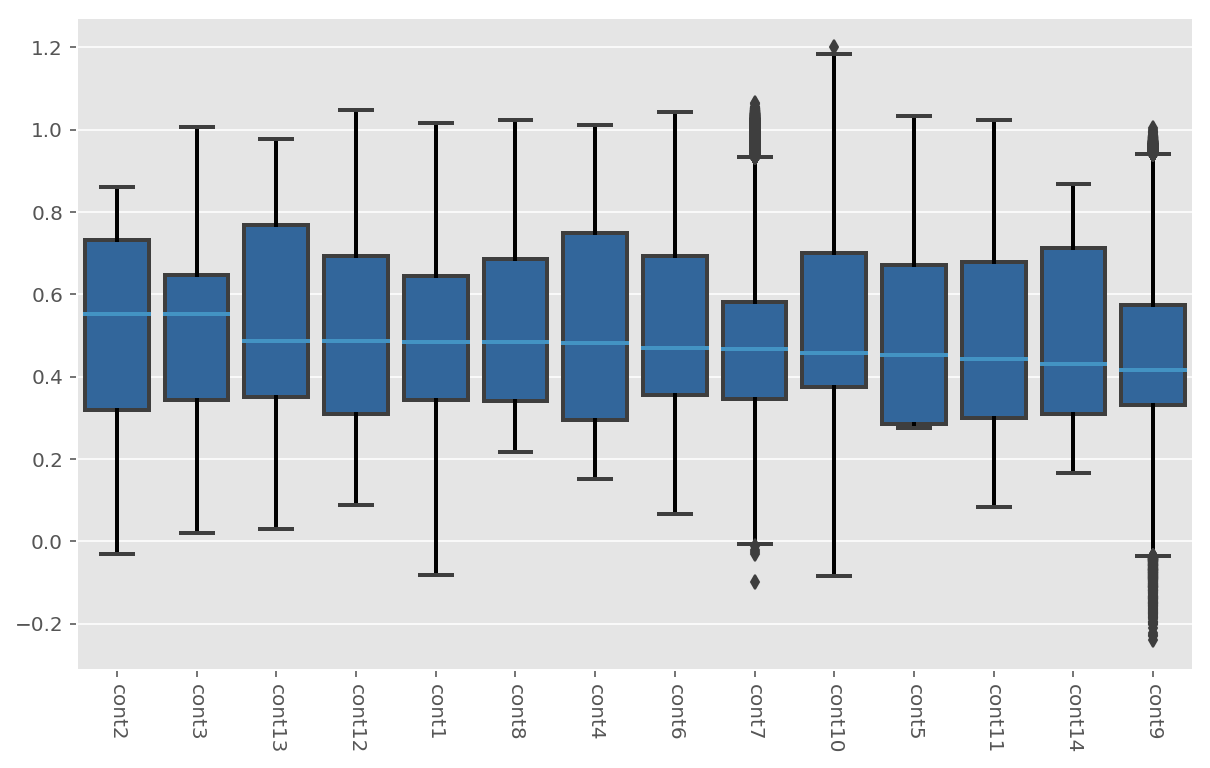

In [45]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=train_sorted, color = '#2166ac', linewidth = 2, whiskerprops=dict(color="black"), medianprops={'color':'#4393c3'})
lab = ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)
# ax.set_facecolor('whitesmoke')

Переменная cont7 имеет выборс, cont9 имеет сильный хвост, однако данные очень чистые, почти нет никаких выбросов, нет пропусков. 

cont12 & cont11 распределены одинаково.

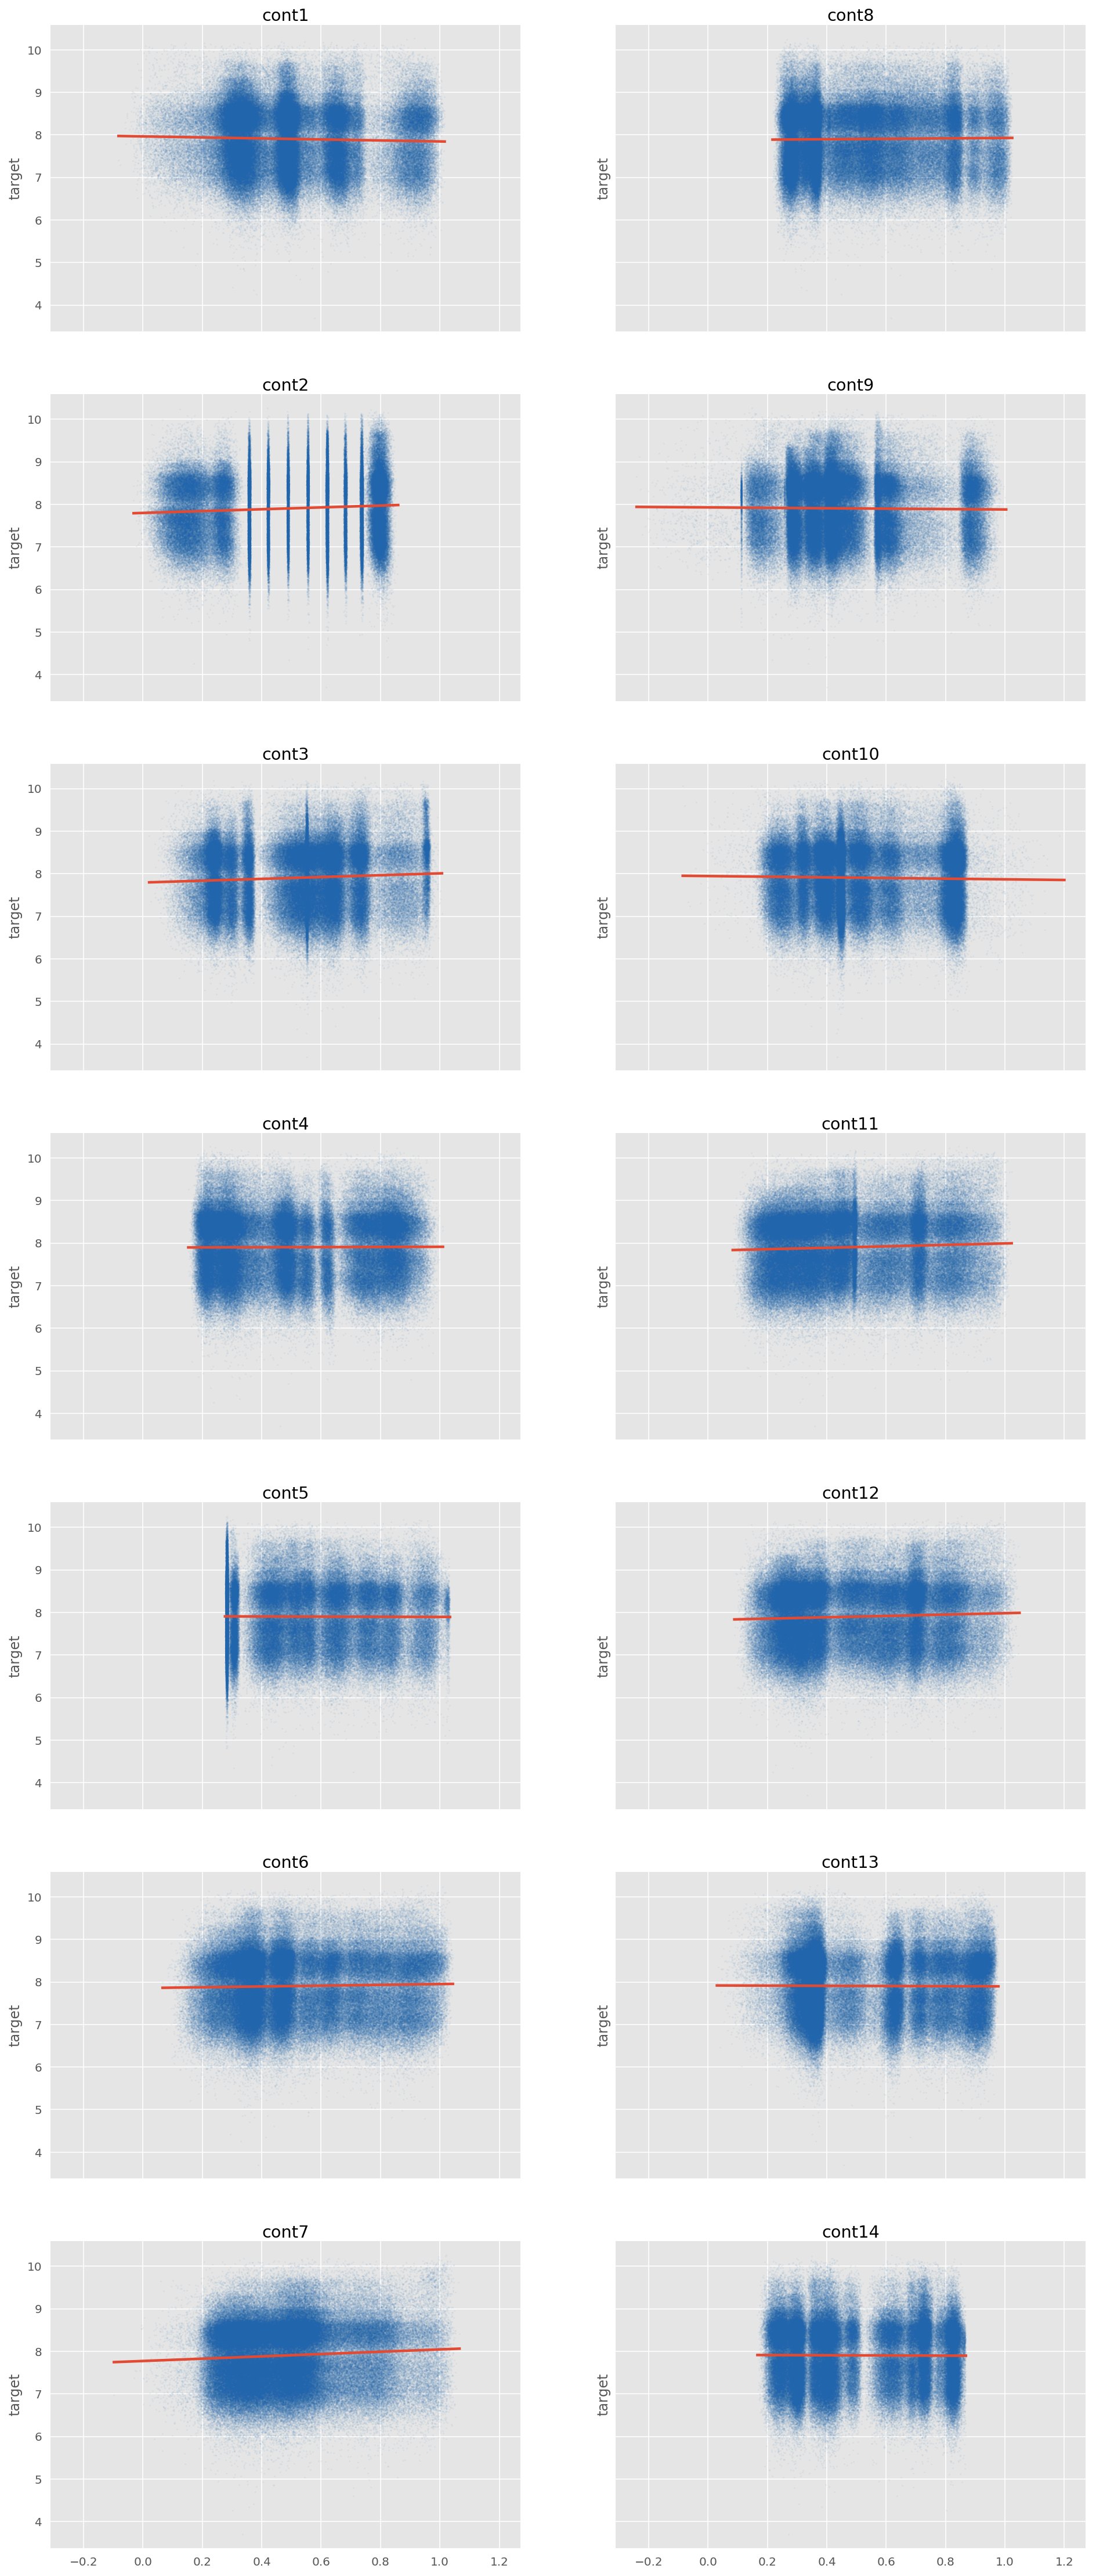

In [157]:
fig, axes = plt.subplots(7, 2, sharex=True, sharey=True, figsize=(16,40))
# fig.suptitle('Relationship between target and independent variables', fontsize=16)
n = 0
for c in train.iloc[:,:7].columns:
    sns.regplot(train[c].values, train['target'], ax=axes[n, 0], scatter_kws={'s':0.1, 'color':'#2166ac' ,'alpha': 0.1})
    axes[n, 0].set_title(train.columns[n], pad = 2.8)
    for tic in axes[n, 0].xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in axes[n, 0].yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    n+=1
k = 0
for c in train.iloc[:,7:14].columns:
    sns.regplot(train[c].values, train['target'], ax=axes[k, 1], scatter_kws={'s':0.1, 'color':'#2166ac' ,'alpha': 0.1})
    axes[k, 1].set_title(train.columns[k + 7], pad = 2.8)
    for tic in axes[k, 1].xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in axes[k, 1].yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    k+=1


In [19]:
def scaller_data(strategy, train_data, test_data):
    train_data=train_data.copy()
    test_data=test_data.copy()
    
    cols=train_data.columns
    train_index=train_data.index
    test_index=test_data.index
    
    if strategy=='StandatScaller':
        scaler=StandardScaler()
    elif strategy=='MinMaxScaler':
        scaler=MinMaxScaler()
    elif strategy=='PowerTransformer':
        scaler=PowerTransformer(method='box-cox')
    elif strategy=='RobustScaler':
        scaler=RobustScaler()
    elif strategy=='Normalizer':
        scaler=Normalizer()
    elif strategy=='QuantileTransformer':
        scaler=QuantileTransformer()
    elif strategy=='None':
        return train_data, test_data
    
    scaler.fit(train_data.values)
    
    train_data=scaler.transform(train_data.values)
    test_data=scaler.transform(test_data.values)
    
    scaled_train_df = pd.DataFrame(train_data, index=train_index, columns=cols)
    scaled_test_df = pd.DataFrame(test_data, index=test_index, columns=cols)
    
    return scaled_train_df, scaled_test_df

In [20]:
strategy_type=['StandatScaller', 'MinMaxScaler', 'PowerTransformer',
               'RobustScaler', 'Normalizer', 'QuantileTransformer', 'None']


In [21]:
train_scaled=train.copy()
test_scaled=test.copy()
train_scaled.iloc[:,:14], test_scaled = scaller_data('StandatScaller', train_scaled.iloc[:,:14], test_scaled)

In [22]:
train_scaled

cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
id                                                                             
1       0.801645  1.373613  0.609710 -0.960766 -0.987330  1.511813  2.224291   
3      -0.582526  0.540005  0.819571 -0.062371  0.642364 -0.352032  0.126636   
4       1.608411 -1.185405 -1.095647 -0.953827  0.474942  1.388927  0.100791   
5       1.538587 -1.480293  0.126166  0.902958 -0.994913  1.186699  1.462583   
8       2.100272 -0.336002 -1.084605  1.564274  0.741236  1.393311 -0.004294   
...          ...       ...       ...       ...       ...       ...       ...   
499995 -1.421243  1.040361  0.633019 -1.116984  0.518046 -0.832087 -1.061165   
499996  0.190833 -1.458448 -1.497189 -1.397345 -0.646394 -0.643294 -0.674360   
499997 -1.090682  1.506164  2.171778 -0.752250 -0.479120 -0.900102  0.208708   
499998 -0.122436  0.545448  0.092019  1.319262 -0.992095 -0.423262 -1.731395   
499999 -0.099237 -1.173774  0.109728 -1.080548 -1.009985  0.503785 -0.085589   

           cont8     cont9    cont10    cont11    cont12    cont13    cont14  \
id                                                                             
1      -1.108222  0.500229  1.282539  1.989734  1.643753  1.415969 -0.952284   
3       0.257073 -0.211118 -0.435470 -0.200174 -0.328421 -0.798697 -0.644592   
4       0.155431  0.649493  1.499990  0.377494  0.780237  1.434274 -0.963638   
5       1.378694  0.582701  0.298779  1.298002  1.421647  1.570710 -1.076584   
8       0.365338  2.108970  1.698722  2.270278  1.797634  1.664891 -0.326260   
...          ...       ...       ...       ...       ...       ...       ...   
499995 -1.021203 -0.739807  1.684246 -0.765760 -1.183829 -0.291211 -1.032295   
499996 -0.836855  0.033492 -0.326731 -0.561955 -0.667385 -1.135713  0.558369   
499997 -1.226172 -0.415310  0.031667  0.035477  0.044538 -1.653772  1.012504   
499998  0.858745 -0.514372  0.632830  2.275151  2.257315 -2.130702 -0.605172   
499999 -0.857961 -0.076627  0.575822  1.355260  0.241221  0.911991 -1.383870   

          target  
id                
1       7.243043  
3       8.203331  
4       7.776091  
5       6.957716  
8       7.951046  
...          ...  
499995  7.385215  
499996  7.242617  
499997  9.592487  
499998  8.207951  
499999  8.890285  

[299999 rows x 15 columns]

#### Обучим регрессор и оптимизируем его


In [23]:
# !pip install optuna  # если хочешь выполнить эти ячейки кода, то раскоммить эту строчку

import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


# 1) XGBoost model:

In [24]:
def objective(trial, data=train_scaled.iloc[:,:14], target=train_scaled.iloc[:,14:]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=12345)
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators' : trial.suggest_int('n_estimators', 2, 900),
        'gamma' : trial.suggest_float('gamma', 0.01, 1),
        'reg_lambda': trial.suggest_int('reg_lambda', 1, 20, log=True),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y, eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds, squared=False)
    
    return rmse


In [25]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# trial = study.best_trial
# print('RMSE: {}'.format(trial.value))
# print("Best hyperparameters: {}".format(trial.params))

#RMSE: 0.6945549210330295
#Best hyperparameters: {'lambda': 0.02063222345041171, 'alpha': 0.2940682038801133, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 893, 'gamma': 0.4165100682875764, 'reg_lambda': 1, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 220}
best_param_XG={'lambda': 0.02063222345041171, 
               'alpha': 0.2940682038801133,
               'colsample_bytree': 0.5, 
               'subsample': 0.5,
               'learning_rate': 0.016,
               'n_estimators': 893,
               'gamma': 0.4165100682875764, 
               'reg_lambda': 1, 
               'max_depth': 20,
               'random_state': 24, 
               'min_child_weight': 220}

# 2)Linear Model

In [26]:
from sklearn.linear_model import LinearRegression


In [27]:
def objective(trial, data=train_scaled.iloc[:,:14], target=train_scaled.iloc[:,14:]):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=12345)
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'normalize': trial.suggest_categorical('normalize', [True, False]),
        
    }
    model = LinearRegression(**param)  
    
    model.fit(train_x,train_y)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds, squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=8)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-01-31 11:43:36,308] A new study created in memory with name: no-name-2ef7a810-95ac-44dc-b6da-cb15dca39a92
[I 2021-01-31 11:43:37,691] Trial 0 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 11:43:37,964] Trial 1 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 11:43:38,258] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 11:43:38,638] Trial 3 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 0.7313440143332884.
[I 2021-01-31 11:43:38,943] Trial 4 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 3

Accuracy: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': True}


In [28]:
linear_params={'fit_intercept': True, 'normalize': True}

In [ ]:
%%time
model = xgb.XGBRegressor(**best_param_XG)  
model.fit(train_scaled.iloc[:,:14],train_scaled.iloc[:,14:])
y_pred_XG=model.predict(test_scaled)



In [ ]:
model2=LinearRegression(**linear_params)  
model2.fit(train_scaled.iloc[:,:14],train_scaled.iloc[:,14:])
y_pred_LR=model2.predict(test_scaled)

In [ ]:
sample_submission['target']=y_pred_XG
sample_submission.to_csv('XGRegressor.csv',index='id')

sample_submission['target']=y_pred_LR
sample_submission.to_csv('LinearRegressor.csv',index='id')

sample_submission['targetXG']=y_pred_XG
sample_submission['targetLR']=y_pred_LR

sample_submission['target']=(sample_submission['targetLR']+sample_submission['targetXG'])/2
del sample_submission['targetXG']
del sample_submission['targetLR']

sample_submission.to_csv('Linear_XG_Regressor.csv',index='id')

Немного не понял этот момент:d
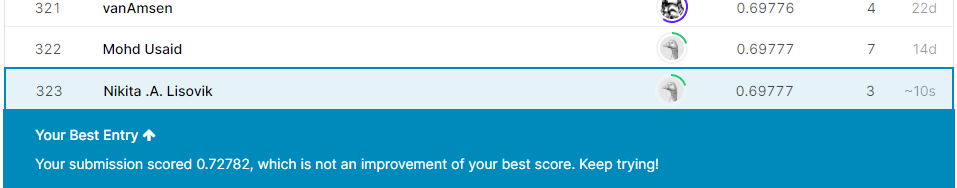

# 3)LightGBM

In [ ]:
def objective(trial, data=train_scaled.iloc[:,:14], target=train_scaled.iloc[:,14:]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=12345)
    param = {
        'boosting_type':'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-6, 5.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-6, 5.0),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005,0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators' : trial.suggest_int('n_estimators', 2, 9000),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2021]),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 1, 30),
        'num_leaves': trial.suggest_int('num_leaves', 1, 300),
        'silent': trial.suggest_categorical('silent', [True, False]),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 30),
        'feature_fraction': trial.suggest_categorical('feature_fraction', [0.005,0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02, 0.5, 0.75]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 500),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.01, 1),
        'cat_smooth' : trial.suggest_float('cat_smooth', 0.01, 1),
        'max_dept':  trial.suggest_int('max_dept', -1, 500),
        'num_iterations' : trial.suggest_int('num_iterations', 2, 900),
        'feature_pre_filter': trial.suggest_categorical('feature_pre_filter', [True, False]),
        'metric': 'rmse'
            }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y, eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds, squared=False)
    
    return rmse

In [40]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# trial = study.best_trial
# print('RMSE: {}'.format(trial.value))
# print("Best hyperparameters: {}".format(trial.params))

#RMSE: 0.6943929415842368
Best_hyperparameters_lgb= {'lambda_l1': 0.5989540062049867,
                           'lambda_l2': 0.0003508966702271487,
                           'subsample': 0.7,
                           'learning_rate': 0.018,
                           'n_estimators': 5137,
                           'random_state': 48,
                           'min_data_per_group': 1,
                           'num_leaves': 244,
                           'silent': True,
                           'bagging_freq': 4,
                           'feature_fraction': 0.75,
                           'min_child_samples': 6,
                           'min_data_in_leaf': 99,
                           'bagging_fraction': 0.7368217822589616,
                           'cat_smooth': 0.9083732030601523,
                           'max_dept': 167,
                           'num_iterations': 893,
                           'feature_pre_filter': True}

In [221]:
%%time
model3 = lgb.LGBMRegressor(**Best_hyperparameters_lgb)
model3.fit(train_scaled.iloc[:,:14],train_scaled.iloc[:,14:])
y_pred_LGB=model3.predict(test_scaled)

[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] lambda_l1 is set=0.5989540062049867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5989540062049867
[LightGBM] [Warning] bagging_fraction is set=0.7368217822589616, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7368217822589616
[LightGBM] [Warning] lambda_l2 is set=0.0003508966702271487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003508966702271487
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Wall time: 1min 23s


In [222]:
sample_submission['target']=y_pred_LGB
sample_submission.to_csv('LGBegressor.csv',index='id')

Лучший скор пока что показывает чистый XGBoost , датасет был преобразован с помощью standartScaller, ещё нужно попробовать другие коммбинации

#### Вторая попытка, попробуем сделать тоже самое ,только без cont12

In [30]:
train = pd.read_csv(path+'train.csv', sep=',', index_col='id')
sample_submission=pd.read_csv(path+'sample_submission.csv', sep=',', index_col='id')
test = pd.read_csv(path+'test.csv', sep=',', index_col='id')

print('train data')

train data


In [31]:
del train['cont11']
del test['cont11']

In [33]:
%%time
model = xgb.XGBRegressor(**best_param_XG)  
model.fit(train.iloc[:,:13],train.iloc[:,13:])
y_pred_XG=model.predict(test)

[11:56:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 20min 39s


In [34]:
sample_submission['target']=y_pred_XG
sample_submission.to_csv('XGRegressor.csv',index='id')

In [42]:
%%time
model3 = lgb.LGBMRegressor(**Best_hyperparameters_lgb)
model3.fit(train.iloc[:,:13],train.iloc[:,13:])
y_pred_LGB=model3.predict(test)

[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] lambda_l1 is set=0.5989540062049867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5989540062049867
[LightGBM] [Warning] bagging_fraction is set=0.7368217822589616, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7368217822589616
[LightGBM] [Warning] lambda_l2 is set=0.0003508966702271487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003508966702271487
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Wall time: 1min 9s


In [43]:
sample_submission['target']=y_pred_LGB
sample_submission.to_csv('LGBegressor.csv',index='id')

In [47]:
%%time
### Попробуем улучшить базовую модель XGBoost
train = pd.read_csv(path+'train.csv', sep=',', index_col='id')
sample_submission=pd.read_csv(path+'sample_submission.csv', sep=',', index_col='id')
test = pd.read_csv(path+'test.csv', sep=',', index_col='id')

train_scaled=train.copy()
test_scaled=test.copy()
train_scaled.iloc[:,:14], test_scaled = scaller_data('StandatScaller', train_scaled.iloc[:,:14], test_scaled)

best_param_XG={'lambda': 0.02063222345041171, 
               'alpha': 0.2940682038801133,
               'colsample_bytree': 0.45, 
               'subsample': 0.45,
               'learning_rate': 0.016,
               'n_estimators': 893,
               'gamma': 0.4165100682875764, 
               'reg_lambda': 1, 
               'max_depth': 18,
               'random_state': 24, 
               'min_child_weight': 220}

model = xgb.XGBRegressor(**best_param_XG)  
model.fit(train_scaled.iloc[:,:14],train_scaled.iloc[:,14:])
y_pred_XG=model.predict(test_scaled)

[12:45:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 18min 12s


In [52]:
def scaller_data(strategy, train_data, test_data):
    train_data=train_data.copy()
    test_data=test_data.copy()
    
    cols=train_data.columns
    train_index=train_data.index
    test_index=test_data.index
    
    if strategy=='StandatScaller':
        scaler=StandardScaler()
    elif strategy=='MinMaxScaler':
        scaler=MinMaxScaler()
    elif strategy=='PowerTransformer':
        scaler=PowerTransformer()
    elif strategy=='RobustScaler':
        scaler=RobustScaler()
    elif strategy=='Normalizer':
        scaler=Normalizer()
    elif strategy=='QuantileTransformer':
        scaler=QuantileTransformer()
    elif strategy=='None':
        return train_data, test_data
    
    scaler.fit(train_data.values)
    
    train_data=scaler.transform(train_data.values)
    test_data=scaler.transform(test_data.values)
    
    scaled_train_df = pd.DataFrame(train_data, index=train_index, columns=cols)
    scaled_test_df = pd.DataFrame(test_data, index=test_index, columns=cols)
    
    return scaled_train_df, scaled_test_df

In [53]:
from sklearn.linear_model import LinearRegression
for scal in strategy_type:
    train_scaled=train.copy()
    test_scaled=test.copy()
    train_scaled.iloc[:,:14], test_scaled = scaller_data(scal, train_scaled.iloc[:,:14], test_scaled)
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=8)
    trial = study.best_trial
    print('RMSEE: {}'.format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))

[I 2021-01-31 13:06:33,083] A new study created in memory with name: no-name-7227ab5d-3300-4857-afc1-709500b31631
[I 2021-01-31 13:06:33,331] Trial 0 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:33,585] Trial 1 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:33,887] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:34,141] Trial 3 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:34,395] Trial 4 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is trial 4

RMSEE: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': False}


[I 2021-01-31 13:06:35,517] A new study created in memory with name: no-name-a9a196c6-59f0-44b1-818c-85cb3a83d02c
[I 2021-01-31 13:06:35,778] Trial 0 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:36,018] Trial 1 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:36,279] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:36,542] Trial 3 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:36,808] Trial 4 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is trial 4

RMSEE: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': False}


[I 2021-01-31 13:06:49,892] A new study created in memory with name: no-name-c5aa9d43-a870-4765-95fa-18cc32300c82
[I 2021-01-31 13:06:50,168] Trial 0 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:50,417] Trial 1 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:50,721] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:50,981] Trial 3 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:51,245] Trial 4 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is tri

RMSEE: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': True}


[I 2021-01-31 13:06:52,476] A new study created in memory with name: no-name-d19f6db6-fdea-45f8-bbc6-651e4c51857f
[I 2021-01-31 13:06:52,711] Trial 0 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:52,976] Trial 1 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.7313440143332884.
[I 2021-01-31 13:06:53,217] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.7313440143332884.
[I 2021-01-31 13:06:53,508] Trial 3 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.7313440143332884.
[I 2021-01-31 13:06:53,812] Trial 4 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': True}. Best is tria

RMSEE: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': True}


[I 2021-01-31 13:06:55,139] A new study created in memory with name: no-name-a5b8ed47-bbc3-452d-aced-027fc759b01f
[I 2021-01-31 13:06:55,399] Trial 0 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:55,654] Trial 1 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:55,957] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:56,213] Trial 3 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.7313440143332884.
[I 2021-01-31 13:06:56,495] Trial 4 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is t

RMSEE: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': False}


[I 2021-01-31 13:06:59,317] A new study created in memory with name: no-name-f7289300-2f57-47df-b496-1f3c761b6747
[I 2021-01-31 13:06:59,567] Trial 0 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:06:59,863] Trial 1 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.7313440143332884.
[I 2021-01-31 13:07:00,156] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.7313440143332884.
[I 2021-01-31 13:07:00,405] Trial 3 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.7313440143332884.
[I 2021-01-31 13:07:00,728] Trial 4 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': True}. Best is trial

RMSEE: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': False}


[I 2021-01-31 13:07:02,121] Trial 0 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:07:02,418] Trial 1 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:07:02,686] Trial 2 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:07:02,940] Trial 3 finished with value: 7.941364209419436 and parameters: {'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.941364209419436.
[I 2021-01-31 13:07:03,232] Trial 4 finished with value: 0.7313440143332884 and parameters: {'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.7313440143332884.
[I 2021-01-31 13:07:03,514] Trial 5 finished with value: 7.941364209419436 and 

RMSEE: 0.7313440143332884
Best hyperparameters: {'fit_intercept': True, 'normalize': False}


#### Вывод - скалирование данных никак не помогло
Попробуем последнюю модель - градиентый бустинг:
    

In [63]:
from sklearn import datasets, ensemble
params_GB = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params_GB)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    train_scaled.iloc[:,:14], train_scaled.iloc[:,14:], test_size=0.2, random_state=12345)


reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.5074


In [65]:
reg = ensemble.GradientBoostingRegressor(**params_GB)  
reg.fit(train_scaled.iloc[:,:14],train_scaled.iloc[:,14:])
y_pred_GB=model.predict(test_scaled)

In [67]:
print(y_pred_GB)
print(y_pred_XG)
print(y_pred_LGB)

[7.8873525 8.009442  7.959552  ... 7.839401  7.921163  8.075421 ]
[7.9496465 7.9304924 7.924235  ... 8.251845  7.9791355 7.9538155]
[7.97288772 7.81683726 7.90896739 ... 8.15473237 8.03529401 7.96747671]


In [68]:
sample_submission['target']=y_pred_GB
sample_submission.to_csv('GBegressor.csv',index='id')

In [70]:
sample_submission['target_XG']=y_pred_XG
sample_submission['target_GB']=y_pred_GB
sample_submission['target']=sample_submission['target_XG']*0.9 + sample_submission['target_GB']*0.1

In [71]:
del sample_submission['target_XG']
del sample_submission['target_GB']
sample_submission.to_csv('GB_01_XG_09.csv',index='id')

Почти весь лидерборд имеет скор меньше ,чем 0.69777 попробуем сгенерить новые фичи модели, либо убрать выбросы. 

In [74]:
#%%time
train = pd.read_csv(path+'train.csv', sep=',', index_col='id')
sample_submission=pd.read_csv(path+'sample_submission.csv', sep=',', index_col='id')
test = pd.read_csv(path+'test.csv', sep=',', index_col='id')


train=train[train['target']>0]
train=train[train['cont7']<1]

train.shape


(298698, 15)

In [73]:
train['cont7'].describe()

count    299999.000000
mean          0.487891
std           0.181096
min          -0.097666
25%           0.346602
50%           0.466825
75%           0.581293
max           1.066167
Name: cont7, dtype: float64

In [76]:
#RMSE: 0.692689026304802
train['cont11']=train['cont12']*train['cont12']
del train['cont12']

test['cont11']=test['cont12']*test['cont12']
del test['cont12']

In [77]:
trial.params={'alpha': 0.039710877551502384,
 'colsample_bytree': 0.4,
 'gamma': 0.4712003554976748,
 'lambda': 0.01655671836618677,
 'learning_rate': 0.016,
 'max_depth': 15,
 'min_child_weight': 175,
 'n_estimators': 892,
 'random_state': 2020,
 'reg_lambda': 1,
 'subsample': 0.7}


reg = xgb.XGBRegressor(**trial.params)  
reg.fit(train.iloc[:,:13],train.iloc[:,13:])
y_pred_GB=reg.predict(test)
sample_submission['target']=y_pred_GB
sample_submission.to_csv('XGBegressor_2.csv',index='id')

[15:43:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [78]:
result={'model':['XGBoost', 'LinearRegression', 'XGBoost and LinearRegression', 'LightGBM', 'XGB_without_cont11', 'LightGBM_without_cont11', 'GradientBoostingRegressor', 'XGboost_pretrained'],
    'Public Score': [0.69777, 0.72782, 0.70552, 0.69837, 0.69944, 0.69956, 0.73860, 0.69958]}

### Лучший результат остался за XGBoost